In [320]:
import numpy as np
import pandas as pd
from scipy.stats import norm
import matplotlib.pyplot as plt

from newsvendor import Newsvendor

In [307]:
# create Newsvendor object
# average demand = 192, std dev = 58, selling price = 131, cost of item = 100, salvage value = 81 
t1 = Newsvendor(192, 58, 131, 100, 81)

In [308]:
# show input parameters using showParameters method
t1.showParameters()

{'Demand': 192,
 'Standard Deviation': 58,
 'Selling Price': 131,
 'Cost': 100,
 'Salvage Value': 81}

In [309]:
# use optimalSummary method to find optimal order/production quantity based on selling, cost, and salvage prices
t1.optimalSummary()

{'Order Quantity': 210,
 'Expected Profit': 4851.46,
 'Expected Sales Quantity': 177.0,
 'Expected Lost Sales Quantity': 15.0,
 'Expected Leftover Quantity': 33.0,
 'Fill Rate': 0.921,
 'Stockout probability': 0.3781}

In [310]:
# targetInStockProba method to find order/production quantity based on desired in-stock probability
# type 1 service level (cycle service level)
# probaility there will be stock
t1.targetInStockProba(0.99)

{'Chosen In-Stock Probability': 0.99,
 'Order Quantity': 327,
 'Expected Profit': 3379.89,
 'Expected Sales Quantity': 192.0,
 'Expected Lost Sales Quantity': 0.0,
 'Expected Leftover Quantity': 135.0,
 'Fill Rate': 0.9993,
 'Stockout probability': 0.01}

In [311]:
# quantityPerformanceSummary method to find the expected values based on the chosen order/production quantity
t1.quantityPerformanceSummary(360)

{'Chosen Order Quantity': 360,
 'Expected Profit': 2750.43,
 'Expected Sales Quantity': 192.0,
 'Expected Lost Sales Quantity': 0.0,
 'Expected Leftover Quantity': 168.0,
 'Fill Rate': 0.999,
 'Stockout probability': 0.0019}

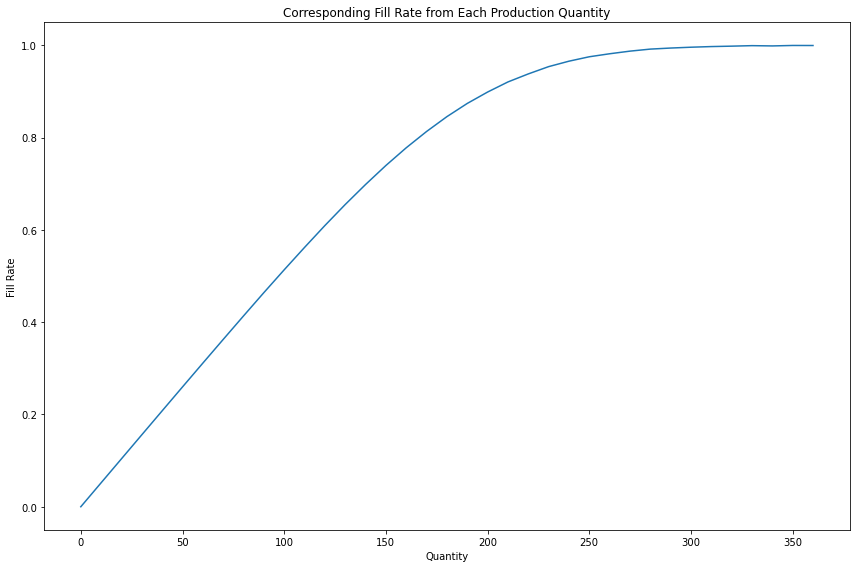

In [312]:
# fillRateSummary method to show corresponding fill rates based on production/order quantity
# upper_SD_bound: how many standard deviations above the mean the method should find fill rate for (SD for t1 = 58)
# in this example: 3 SD's; therefore 192 + (3 x 58) is the upper bound
# steps is how often to test
# if only the df is required, set showGraph=False (default)
df_fillrate = t1.fillRateSummary(upper_SD_bound=3, steps=10, showGraph=True)
# returns df with order quantity and fill rate, set to variable to access for later use

In [301]:
# quantityScreen method 
# screen profit, max profit, min profit, units sold, lost sales, and leftover units
# over an upper range decided by how many SD's above the mean 
# can get more granular quantities by using smaller steps between quantities 
# returns df
df_screen = t1.quantityScreen(upper_SD_bound=3, steps=10)

In [302]:
# tail view of df_screen df
df_screen.tail()

,Avg Profit,Max Profit,Min Profit,Avg Units Sold,Avg Lost Sales,Avg Leftover Units
Units,,,,,,
320,3500.99,9920.0,-10380.0,192.0,0.0,128.0
330,3320.66,10230.0,-10820.0,192.0,0.0,138.0
340,3135.30,10540.0,-10810.0,192.0,0.0,148.0
350,2947.06,10850.0,-11200.0,192.0,0.0,158.0
360,2759.68,11160.0,-11740.0,192.0,0.0,168.0


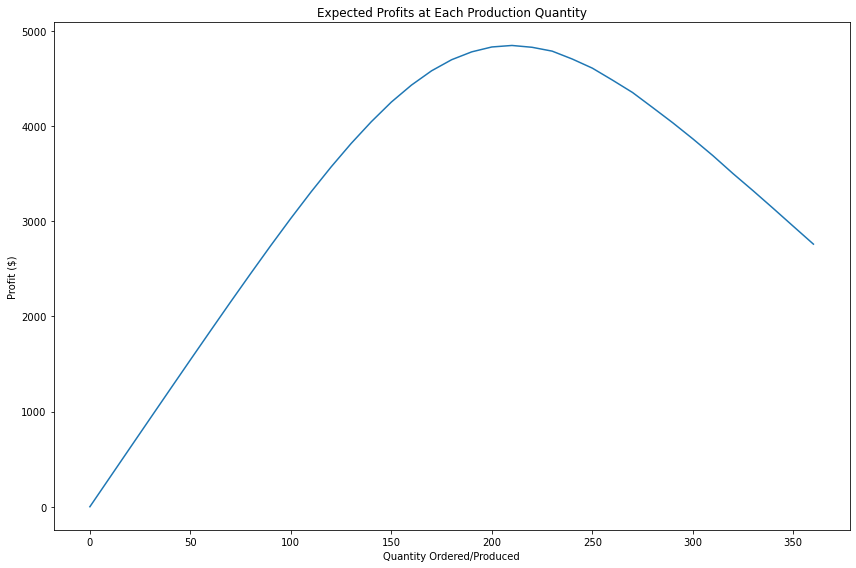

In [317]:
# visuablize profits over a range of quantities 

fig, ax = plt.subplots(figsize=(12,8))
ax.set_title('Expected Profits at Each Production Quantity')
ax.set_xlabel('Quantity Ordered/Produced')
ax.set_ylabel('Profit ($)')
ax.plot(df_screen.index, df_screen['Avg Profit'])

fig.tight_layout()
plt.show()

In [321]:
class Newsvendor:
    def __init__(self, demand, SD, sell, cost, salvage):
        self.mu = demand
        self.SD = SD
        self.sellprice = sell
        self.cost = cost
        self.salvageprice = salvage
        self._Cu = self.sellprice - self.cost
        self._Co = self.cost - self.salvageprice
        self._criticalRatio = self._Cu / (self._Cu + self._Co)
        
        
    def clearParameters(self):
        self.mu = 0
        self.SD = 0
        self.sellprice = 0
        self.cost = 0
        self.salvage = 0
        self._Cu = 0
        self._Co = 0
        self._criticalRatio = 0
        
    def setParameters(self, demand, SD, sell, cost, salvage):
        self.mu = demand
        self.SD = SD
        self.sellprice = sell
        self.cost = cost
        self.salvageprice = salvage
        self._Cu = self.sellprice - self.cost
        self._Co = self.cost - self.salvageprice
        self._criticalRatio = self._Cu / (self._Cu + self._Co)
        
    def showParameters(self):
        summary = {'Demand': self.mu,
                  'Standard Deviation': self.SD,
                  'Selling Price': self.sellprice,
                  'Cost': self.cost,
                  'Salvage Value': self.salvageprice}
        
        return summary
        
    def optimalQuantity(self):
        optimal_production = round(norm(self.mu, self.SD).ppf(self._criticalRatio))
        safety_stock = optimal_production - self.mu
        quantity_summary = {'optimal quantity': optimal_production, 'average demand': self.mu, 'safety stock': safety_stock}
        
        return quantity_summary
    
    def optimalSummary(self, simulations=1, trials=1000000):
        production = round(norm(self.mu, self.SD).ppf(self._criticalRatio))
        demand = np.round(np.random.normal(self.mu, self.SD, (simulations, trials)))

        # salvage quantities
        salvage_quantity = production - demand
        salvage_quantity = np.where(salvage_quantity<0, 0, salvage_quantity)
        salvage_revenue = salvage_quantity * self.salvageprice

        # expected lost sales
        lost_sales_quantity = demand - production
        lost_sales_quantity = np.where(lost_sales_quantity<0, 0, lost_sales_quantity)

        # items sold
        units_sold = np.minimum(demand, production)

        # item rev
        unit_revenue = units_sold * self.sellprice

        # total rev
        TR = unit_revenue + salvage_revenue

        # COGS
        COGS = production * self.cost

        # gross profit
        GP = TR - COGS
        
        dict_summ = {'Order Quantity': production,
                    'Expected Profit': round(np.mean(GP), 2),
                    'Expected Sales Quantity': round(np.mean(units_sold), 0),
                    'Expected Lost Sales Quantity': np.round(np.mean(lost_sales_quantity), 0),
                    'Expected Leftover Quantity': round(np.mean(salvage_quantity), 0),
                    'Fill Rate': round(np.mean(units_sold) / self.mu, 4),
                    'Stockout probability': round(norm.sf((production-self.mu)/self.SD), 4)}
        
        
        
        return dict_summ
    
    def targetInStockProba(self, instock_pct, simulations=1, trials=1000000):
        production = round(norm(self.mu, self.SD).ppf(instock_pct))
        demand = np.round(np.random.normal(self.mu, self.SD, (simulations, trials)))

        # salvage quantities
        salvage_quantity = production - demand
        salvage_quantity = np.where(salvage_quantity<0, 0, salvage_quantity)
        salvage_revenue = salvage_quantity * self.salvageprice

        # expected lost sales
        lost_sales_quantity = demand - production
        lost_sales_quantity = np.where(lost_sales_quantity<0, 0, lost_sales_quantity)
        avg_lost_sales = round(np.mean(lost_sales_quantity), 0) #for dict_summ

        # items sold
        units_sold = np.minimum(demand, production)

        # item rev
        unit_revenue = units_sold * self.sellprice

        # total rev
        TR = unit_revenue + salvage_revenue

        # COGS
        COGS = production * self.cost

        # gross profit
        GP = TR - COGS
        
        dict_summ = {'Chosen In-Stock Probability': instock_pct,
                    'Order Quantity': production,
                    'Expected Profit': round(np.mean(GP), 2),
                    'Expected Sales Quantity': round(np.mean(units_sold), 0),
                    'Expected Lost Sales Quantity': avg_lost_sales,
                    'Expected Leftover Quantity': round(np.mean(salvage_quantity), 0),
                    'Fill Rate': round(np.mean(units_sold) / self.mu, 4),
                    'Stockout probability': round(norm.sf((production-self.mu)/self.SD), 4)}
        
        return dict_summ
    
    def quantityPerformanceSummary(self, quantity, simulations=1, trials=1000000):
        production = quantity
        demand = np.round(np.random.normal(self.mu, self.SD, (simulations, trials)))

        # salvage quantities
        salvage_quantity = production - demand
        salvage_quantity = np.where(salvage_quantity<0, 0, salvage_quantity)
        salvage_revenue = salvage_quantity * self.salvageprice

        # expected lost sales
        lost_sales_quantity = demand - production
        lost_sales_quantity = np.where(lost_sales_quantity<0, 0, lost_sales_quantity)
        avg_lost_sales = round(np.mean(lost_sales_quantity), 0) #for dict_summ

        # items sold
        units_sold = np.minimum(demand, production)

        # item rev
        unit_revenue = units_sold * self.sellprice

        # total rev
        TR = unit_revenue + salvage_revenue

        # COGS
        COGS = production * self.cost

        # gross profit
        GP = TR - COGS
        
        dict_summ = {'Chosen Order Quantity': production,
                    'Expected Profit': round(np.mean(GP), 2),
                    'Expected Sales Quantity': round(np.mean(units_sold), 0),
                    'Expected Lost Sales Quantity': avg_lost_sales,
                    'Expected Leftover Quantity': round(np.mean(salvage_quantity), 0),
                    'Fill Rate': round(np.mean(units_sold) / self.mu, 4),
                    'Stockout probability': round(norm.sf((production-self.mu)/self.SD), 4)}
                
        return dict_summ
    
    def fillRateSummary(self, upper_SD_bound=3, steps=10, showGraph=False, simulations=1, trials=1000000):
        
        # set bounds for testing production quantities
        upper_production_bound = self.mu + (upper_SD_bound * self.SD) # upper limit set by number of SD away from mean
        unit_production_range = range(0, upper_production_bound, steps)
        
        # create arrays to store fill rates
        fill_rate_array = np.zeros(len(unit_production_range))
        
        for i, j in enumerate(unit_production_range):
            production = j
            demand = np.round(np.random.normal(self.mu, self.SD, (simulations, trials)))
            
            # average of units_sold array is numerator component of fill rate
            units_sold = np.minimum(demand, production)
            
            fill_rate_array[i] = round(np.mean(units_sold) / self.mu, 4)
        
        # create dataframe
        df_fill_rate = pd.DataFrame({
            'Quantity': np.array(unit_production_range),
            'Fill Rate': fill_rate_array
        }).set_index('Quantity')
        
        
        if showGraph==True:

            fig, ax = plt.subplots(figsize=(12,8))
            ax.set_title('Corresponding Fill Rate from Each Production Quantity')
            ax.set_xlabel('Quantity')
            ax.set_ylabel('Fill Rate')
            ax.plot(df_fill_rate.index, df_fill_rate['Fill Rate'])
            
            fig.tight_layout()
            plt.show()
            
        else:
            None
        
        return df_fill_rate
    
    def quantityScreen(self, upper_SD_bound=3, steps=10, simulations=1, trials=1000000):
        upper_production_bound = self.mu +(upper_SD_bound * self.SD)
        unit_production_range = range(0, upper_production_bound, steps)
        
        # create arrays to store data
        avg_profit_list = np.zeros(len(unit_production_range))
        max_profit_list = np.zeros(len(unit_production_range))
        min_profit_list = np.zeros(len(unit_production_range))
        avg_units_sold = np.zeros(len(unit_production_range))
        avg_lost_sales = np.zeros(len(unit_production_range))
        avg_leftover_units = np.zeros(len(unit_production_range))
        
        for i, j in enumerate(unit_production_range):
            production = j
            demand = np.round(np.random.normal(self.mu, self.SD, (simulations, trials)))
            
            # salvage quantities
            salvage_quantity = production - demand
            salvage_quantity = np.where(salvage_quantity<0, 0, salvage_quantity)
            salvage_revenue = salvage_quantity * self.salvageprice
            
            # expected lost sales
            lost_sales_quantity = demand - production
            lost_sales_quantity = np.where(lost_sales_quantity<0, 0, lost_sales_quantity)


            # items sold
            units_sold = np.minimum(demand, production)

            # item rev
            unit_revenue = units_sold * self.sellprice

            # total rev
            TR = unit_revenue + salvage_revenue

            # COGS
            COGS = production * self.cost

            # gross profit
            GP = TR - COGS
            
            avg_profit_list[i] = round(np.mean(GP),2)
            max_profit_list[i] = round(np.max(GP),2)
            min_profit_list[i] = round(np.min(GP),2)
            avg_units_sold[i] = round(np.mean(units_sold), 0)
            avg_lost_sales[i] = round(np.mean(lost_sales_quantity),0)
            avg_leftover_units[i] = round(np.mean(salvage_quantity),0)
            
        df_summ = pd.DataFrame({
            'Units': unit_production_range,
            'Avg Profit': avg_profit_list,
            'Max Profit': max_profit_list,
            'Min Profit': min_profit_list,
            'Avg Units Sold': avg_units_sold,
            'Avg Lost Sales': avg_lost_sales,
            'Avg Leftover Units': avg_leftover_units
        }).set_index('Units')
        
        return df_summ